<a href="https://colab.research.google.com/github/Aryan4884/Assignment-1/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openai-whisper pydub librosa matplotlib scikit-learn
# 📦 Step 1: Install Compatible Libraries
!pip install numpy==1.23.5
!pip install librosa==0.10.0.post2
!pip install SpeechRecognition
!pip install nltk
!pip install praat-parselmouth

# 🔄 Restart Runtime After This Cell! Then re-run from here:


In [ ]:
# 🔄 Restart Runtime After This Cell! Then re-run from here:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
import os
import numpy as np
import librosa
import whisper
import matplotlib.pyplot as plt
import speech_recognition as sr
import parselmouth
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')

from pydub import AudioSegment, silence
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import files

uploaded = files.upload()  # Upload 5-10 .wav files
audio_files = list(uploaded.keys())


Saving common_voice_en_41910677.mp3 to common_voice_en_41910677.mp3
Saving common_voice_en_41910678.mp3 to common_voice_en_41910678.mp3
Saving common_voice_en_41910679.mp3 to common_voice_en_41910679.mp3
Saving common_voice_en_41910680.mp3 to common_voice_en_41910680.mp3
Saving common_voice_en_41910681.mp3 to common_voice_en_41910681.mp3
Saving common_voice_en_41910682.mp3 to common_voice_en_41910682.mp3


In [ ]:
from pydub import AudioSegment
import os

# Ensure ffmpeg is available
!apt-get install -y ffmpeg
!pip install pydub

# Convert uploaded files to WAV
converted_files = []
for file in uploaded:
    if not file.endswith('.wav'):
        sound = AudioSegment.from_file(file)
        wav_file = file.rsplit('.', 1)[0] + ".wav"
        sound.export(wav_file, format="wav")
        converted_files.append(wav_file)
    else:
        converted_files.append(file)

audio_files = converted_files


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [ ]:
model = whisper.load_model("base")

def transcribe_audio(file_path):
    result = model.transcribe(file_path)
    return result["text"]

transcripts = {file: transcribe_audio(file) for file in audio_files}


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/

In [ ]:
HESITATION_MARKERS = ['uh', 'um', 'erm', 'ah', 'eh']
COMMON_SUBSTITUTIONS = ['thing', 'stuff', 'that', 'you know']
INCOMPLETE_ENDINGS = ['and', 'but', 'so', 'because']

def extract_speech_features(audio_path):
    y, sr_rate = librosa.load(audio_path, sr=None)
    duration = librosa.get_duration(y=y, sr=sr_rate)

    # 🎵 Pitch Variability
    snd = parselmouth.Sound(audio_path)
    pitch = snd.to_pitch()
    pitch_values = pitch.selected_array['frequency']
    pitch_values = pitch_values[pitch_values > 0]
    pitch_std = np.std(pitch_values) if len(pitch_values) > 0 else 0

    # 🧠 Speech to Text
    recognizer = sr.Recognizer()
    with sr.AudioFile(audio_path) as source:
        audio_data = recognizer.record(source)
        try:
            text = recognizer.recognize_google(audio_data)
        except:
            text = ""

    sentences = sent_tokenize(text)
    words = word_tokenize(text.lower())

    # ⏸️ Pauses per Sentence
    pauses = librosa.effects.split(y, top_db=30)
    pause_durations = []
    for i in range(1, len(pauses)):
        silence = pauses[i][0] - pauses[i-1][1]
        pause_durations.append(silence / sr_rate)
    avg_pauses = len(pause_durations) / len(sentences) if sentences else 0

    # 🙊 Hesitations
    hesitation_count = sum(words.count(h) for h in HESITATION_MARKERS)

    # 🔁 Substitutions
    substitution_count = sum(words.count(w) for w in COMMON_SUBSTITUTIONS)

    # 🚀 Speech Rate
    speech_rate = (len(words) / duration) * 60 if duration > 0 else 0

    # 🧩 Sentence Completion
    incomplete_sentences = sum(1 for s in sentences if any(s.strip().lower().endswith(w) for w in INCOMPLETE_ENDINGS))

    return {
        "text": text,
        "pauses_per_sentence": avg_pauses,
        "hesitation_count": hesitation_count,
        "substitution_count": substitution_count,
        "speech_rate": speech_rate,
        "pitch_std": pitch_std,
        "incomplete_sentences": incomplete_sentences
    }

In [ ]:
from pydub import AudioSegment

for file in audio_files:
    if not file.lower().endswith(('.wav', '.aiff', '.aifc', '.flac')):  # Check if file needs conversion
        # Assuming it's an MP3, adjust if it's another format
        sound = AudioSegment.from_mp3(file)
        new_file_name = os.path.splitext(file)[0] + ".wav"
        sound.export(new_file_name, format="wav")

        # Update audio_files list with the new file name
        audio_files.remove(file)
        audio_files.append(new_file_name)

In [ ]:
# ... previous code ...

features = [extract_speech_features(file) for file in audio_files] # define features by calling extract_speech_features

if len(features) >= 2:
    # Extract only numerical feature values for scaling
    X = [list(f.values())[1:] for f in features]
    X = np.array(X)
    X_scaled = StandardScaler().fit_transform(X)

    kmeans = KMeans(n_clusters=2, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    for idx, file in enumerate(audio_files):
        print(f"{file}: Cluster {labels[idx]}")
else:
    print("Need at least 2 audio files for clustering.")
# ... rest of the code ...

common_voice_en_41910677.wav: Cluster 0
common_voice_en_41910678.wav: Cluster 1
common_voice_en_41910679.wav: Cluster 0
common_voice_en_41910680.wav: Cluster 1
common_voice_en_41910681.wav: Cluster 1
common_voice_en_41910682.wav: Cluster 1


common_voice_en_41910677.wav: Cluster 0
common_voice_en_41910678.wav: Cluster 1
common_voice_en_41910679.wav: Cluster 0
common_voice_en_41910680.wav: Cluster 1
common_voice_en_41910681.wav: Cluster 1
common_voice_en_41910682.wav: Cluster 1


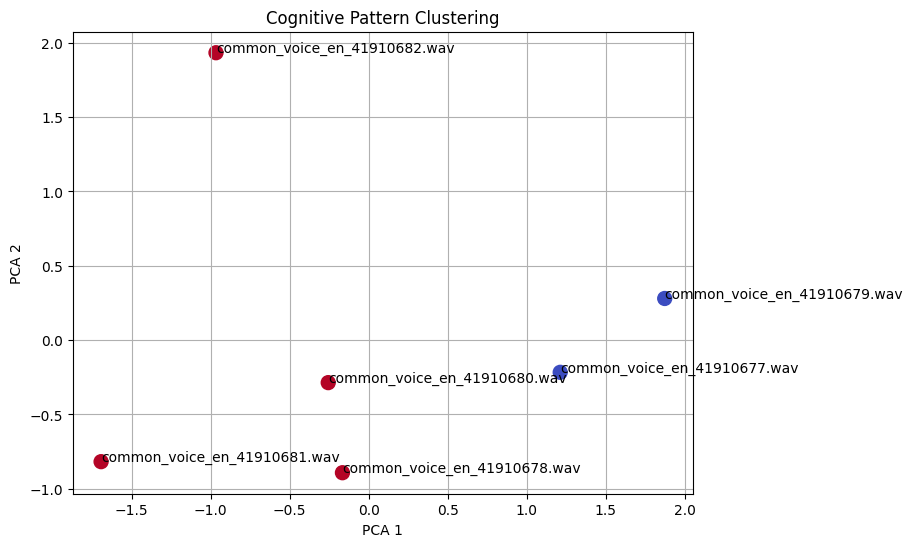

In [ ]:
# ... previous code ...
# In cell 'ipython-input-11-8870b5e2b159'
features = [extract_speech_features(file) for file in audio_files] # define features by calling extract_speech_features

if len(features) >= 2:
    X = [list(f.values())[1:] for f in features] #extract feature values for scaling
    X = np.array(X)
    X_scaled = StandardScaler().fit_transform(X)

    kmeans = KMeans(n_clusters=2, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    for idx, file in enumerate(audio_files):
        print(f"{file}: Cluster {labels[idx]}")
else:
    print("Need at least 2 audio files for clustering.")

# In cell 'ipython-input-12-8870b5e2b159'
if len(features) >= 2: # Check if we have at least 2 samples and if features have been processed
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(X_scaled)

    plt.figure(figsize=(8,6))
    plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap='coolwarm', s=100)
    for i, file in enumerate(audio_files):
        plt.annotate(file, (reduced[i,0], reduced[i,1]))
    plt.title("Cognitive Pattern Clustering")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True)
    plt.show()
else:
    print("Not enough samples for PCA and clustering. Please provide at least 2 audio files.")
# ... rest of the code ...